<a href="https://colab.research.google.com/github/Iveynganga/MACHINE-LEARNING-2/blob/main/Week2ProjectClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Preprocessing

In [9]:
import pandas as pd

# Load the dataset from an Excel file
data = pd.read_excel('/content/Online Retail.xlsx')

# Display the first few rows of the dataframe
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [12]:
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Handling Missingness

In [11]:
# Identify missing values
missing_values = data.isnull().sum()

# Display the missing values count for each feature
print(missing_values)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


# 2. Feature Engineering

In [13]:
# Aggregate data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'InvoiceNo': 'nunique',
    'UnitPrice': 'mean'
}).reset_index()

# Calculate Total Spend
customer_data['TotalSpend'] = customer_data['Quantity'] * customer_data['UnitPrice']

# Rename columns for clarity
customer_data.columns = ['CustomerID', 'TotalQuantity', 'NumInvoices', 'AvgUnitPrice', 'TotalSpend']

# Display the first few rows of the aggregated dataframe
customer_data.head()


,CustomerID,TotalQuantity,NumInvoices,AvgUnitPrice,TotalSpend
0,12346.0,0,2,1.040000,0.000000
1,12347.0,2458,7,2.644011,6498.979011
2,12348.0,2341,4,5.764839,13495.487419
3,12349.0,631,1,8.289041,5230.384932
4,12350.0,197,1,3.841176,756.711765


# 3. Prepare Data for Clustering
Drop customer ID and handle description

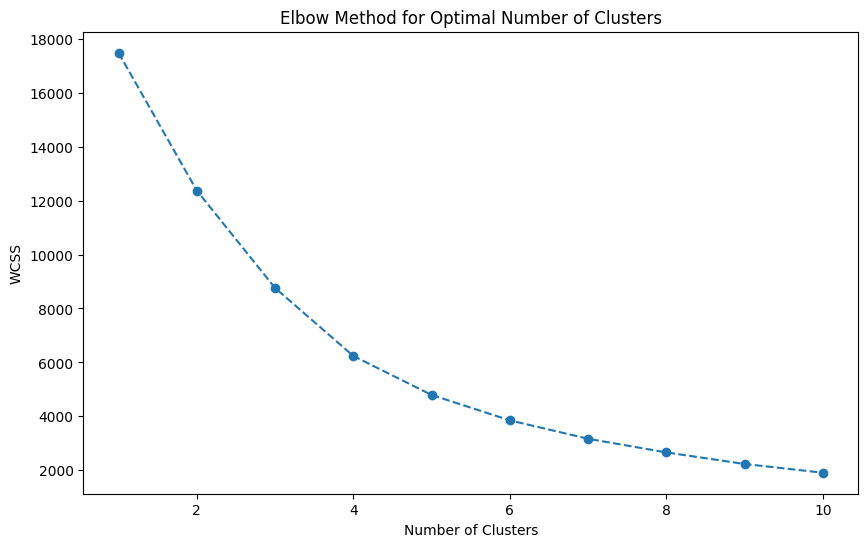

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Features for clustering
features = customer_data[['TotalQuantity', 'NumInvoices', 'AvgUnitPrice', 'TotalSpend']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


# 4. Fit K-means and Evaluate Cluster Quality

In [21]:
from sklearn.metrics import silhouette_score

# Fit K-means with the optimal number of clusters (let's assume it's 4 for this example)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate silhouette score
sil_score = silhouette_score(scaled_features, customer_data['Cluster'])
print(f'Silhouette Score: {sil_score}')


Silhouette Score: 0.9533336136679889


# 5. Analyze and Interpret Clusters

In [22]:
# Load the dataset from an Excel file
data = pd.read_excel('/content/Online Retail.xlsx')

# Analyze and interpret the characteristics of each cluster
cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalQuantity': 'mean',
    'NumInvoices': 'mean',
    'AvgUnitPrice': 'mean',
    'TotalSpend': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'NumCustomers'}).reset_index()

cluster_summary


,Cluster,TotalQuantity,NumInvoices,AvgUnitPrice,TotalSpend,NumCustomers
0,0,881.582241,4.648263,5.105930,2.954454e+03,4347
1,1,20949.500000,45.000000,130.844300,2.261296e+06,2
2,2,29.500000,3.000000,6171.705000,2.395296e+05,2
3,3,49175.809524,89.904762,3.899891,2.007600e+05,21


# 6. Visualize the Clusters

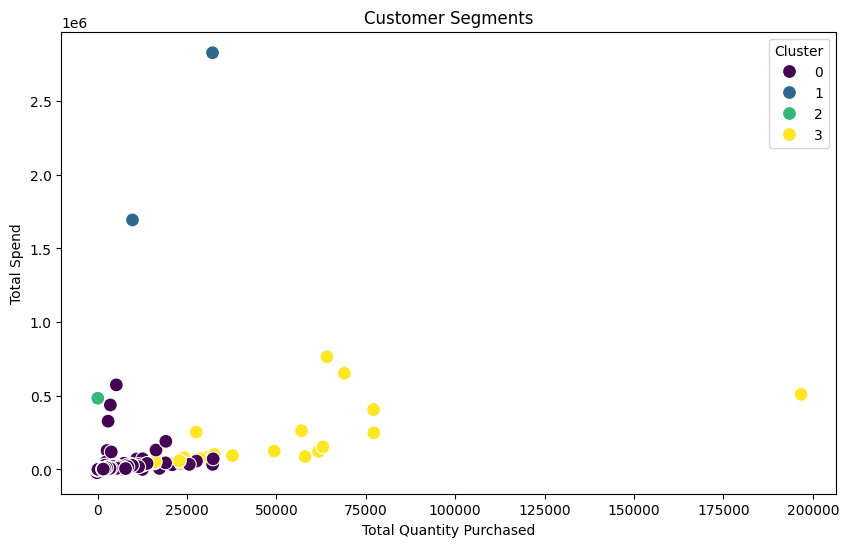

In [23]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='TotalQuantity', y='TotalSpend', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segments')
plt.xlabel('Total Quantity Purchased')
plt.ylabel('Total Spend')
plt.legend(title='Cluster')
plt.show()
